# Catching the Culprit: An analysis of crime clearance rates

# Introduction

The problem of violence plagues many communities. This can be exacerbated by where police choose to place their resources. I was curious to look at the data for N crime reports from Y cities over time period Z to see what factors were empirically related to whether a case was cleared or not.

# Loading Data 

In [14]:
import zipfile
import pandas as pd
from pandas_profiling import ProfileReport
import random

#zf = zipfile.ZipFile("https://github.com/alexmjn/Predicting-Arrests/blob/master/offenses-standardized.csv.zip")
#crime = pd.read_csv(zf.open("offenses.standardized.csv"))

import category_encoders as ce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance

from pandas_profiling import ProfileReport
from pdpbox import pdp
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb

from IPython.display import display

In [15]:
filename = "C:/Users/ajenk/GitHub/Crime_Data/offenses-standardized.csv"
random.seed(42)
p = .3
fields = ["agency_name", "occurred_date", 
          "occurred_time", "firearm_ind", "offense_group", "domestic_violence_ind", "victim_age",
          "victim_race", "victim_ethnicity", "victim_race_condensed", "victim_sex", "clearance_group"]

crime = pd.read_csv(filename, usecols = fields, skiprows = lambda i: i > 0 and random.random() > p)

#functionalize recall of data?

# Baseline Models

## Mean Classification

I begin by reading in a subset of my large data set. When I get to a point at which I feel confident about my model, I will fit the data on the whole set. I also begin by only reading in specific columns; most of the remaining columns are redundant, extremely messy, or largely-missing. To improve model performance I may go back and see if any of these columns can be encoded in a way that makes conceptual sense and improves the model's predictions.

In [41]:
train, test = train_test_split(crime, test_size = .2, random_state = 42)

In [42]:
train, val = train_test_split(train, test_size = .2, random_state = 42)

In [5]:
train["clearance_group"].value_counts()

Open & No Arrest-Unspecified           85281
Cleared-Arrest & Arrest-Unspecified    44481
Cleared/Closed-Unspecified              7546
Cleared-Ex                              6003
Null, Missing, Unclear                    45
Name: clearance_group, dtype: int64

In [43]:
def create_binary_target(df):
    df = df.copy()
    df["cleared"] = ~(df["clearance_group"] == "Open & No Arrest-Unspecified")
    df = df.drop(["clearance_group"], axis = 1)
    return df

In [44]:
train = create_binary_target(train)
val = create_binary_target(val)
test = create_binary_target(test)

In [8]:
train["cleared"].value_counts(normalize = True)

False    0.59489
True     0.40511
Name: cleared, dtype: float64

Only 40.5% of the cases in this data set were actually cleared. Over the course of this analysis, I'll dig into the reasons some cases might be cleared more frequently than others; for now, I'll note that the 59.5% "uncleared" rate can be treated as a naive model, and thus is a benchmark for accuracy that our model should strive to exceed.

## Baseline Random Forest

In [9]:
train.columns

Index(['agency_name', 'occurred_date', 'occurred_time', 'firearm_ind',
       'offense_group', 'domestic_violence_ind', 'victim_age', 'victim_race',
       'victim_ethnicity', 'victim_race_condensed', 'victim_sex', 'cleared'],
      dtype='object')

In [45]:
target = "cleared"
features = train.drop([target], axis = 1).columns.to_list()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [16]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(),
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['agency_name', 'occurred_date',
                                      'occurred_time', 'firearm_ind',
                                      'offense_group', 'domestic_violence_ind',
                                      'victim_age', 'victim_race',
                                      'victim_ethnicity',
                                      'victim_race_condensed', 'victim_sex'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'agency_name',
                                          'd...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_

In [17]:
pipeline.score(X_val, y_val)

0.6526785714285714

In [18]:
model = pipeline.named_steps["randomforestclassifier"]

In [21]:
with open('model_log.txt', 'a') as file:
    file.write(f'Validation accuracy: {pipeline.score(X_val, y_val):.5f}\n')
    file.write(f'Features: {X_train.columns}\n')
    file.write(f'{model.get_params}\n')
    file.write('\n')
    file.close()

Next I fit a quick random forest with no tuning or feature selection. This manages to obtain 65% accuracy in classifying the validation set. Given that it's unlikely this is the optimal model, this is a number that can help guide our judgment in evaluating future models. 

## Baseline Logistic

I also want to fit a quick logistic model to the untuned data. This will help guide my intuition for which type of model best fits the data. Additionally, it will help clarify baseline model performance. However, the data in its current form is not well-suited to logistic regression; there are several high-cardinality variables such as raw date and time metrics. I will explore my data and do some preliminary wrangling before testing my first logistic model.

### Logistic Model Preparation: Basic Feature Cleanup

In [3]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe()
profile

In [46]:
def extract_time_and_date(df):
    df["occurred_date"] = pd.to_datetime(df["occurred_date"], infer_datetime_format=True)
    df["occurred_time"] = pd.to_datetime(df["occurred_time"], infer_datetime_format=True)
    
    df["hour"] = df["occurred_time"].dt.hour
    df["hour_zero"] = df["occurred_time"] == pd.to_datetime("00:00")
    df["year"] = df["occurred_date"].dt.year
    df["month"] = df["occurred_date"].dt.month
    
    df = df.drop(["occurred_date", "occurred_time"], axis = 1)
    return df

def clean_age_category(df):
    df["victim_age"] = df["victim_age"].replace({"UNDER 18": "17"})
    df["victim_age"] = df["victim_age"].astype("float")
    
    #df["victim_age_group"] = pd.cut(df["victim_age"], range(0, 100, 6))
    #df = df.drop(["victim_age"], axis = 1)
    #this code returns a series of ranges which sklearn doesn't like; forest models 
    #should be able to turn numerical data into "categories" anyways
    return df

In [47]:
def wrangle(df):
    df = df.copy()
    df = extract_time_and_date(df)
    df = clean_age_category(df)
    
    return df

In [48]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [49]:
features = train.drop([target], axis = 1).columns.to_list()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [50]:
train.columns

Index(['agency_name', 'firearm_ind', 'offense_group', 'domestic_violence_ind',
       'victim_age', 'victim_race', 'victim_ethnicity',
       'victim_race_condensed', 'victim_sex', 'cleared', 'hour', 'hour_zero',
       'year', 'month'],
      dtype='object')

In [51]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((143356, 13), (143356,), (35840, 13), (35840,), (44799, 13), (44799,))

## Fitting Logistic Model

In [52]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

pipeline.fit(X_train, y_train)

C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['agency_name', 'firearm_ind',
                                     'offense_group', 'domestic_violence_ind',
                                     'victim_race', 'victim_ethnicity',
                                     'victim_race_condensed', 'victim_sex'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(a...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                     

In [53]:
pipeline.score(X_val, y_val)

0.6905412946428572

In [54]:
pipeline.score(X_train, y_train)

0.6905466112335724

A logistic model fits the training data and test data reasonably well. It fits them better than our first random forest, though the data has been somewhat tuned since them. The 69.1% accuracy serves as a new benchmark. To beat these, we take a deeper dive into our data set.

# Exploring the Data

In [11]:
test = "num_obs"
test.replace("_", " ").title()

'Num Obs'

In [12]:
def generate_most_common(feature):
    train_plot = train.copy()
    top_obs = train_plot[feature].value_counts()[:8].index
    train_plot.loc[~train_plot[feature].isin(top_obs), feature] = "other"
    
    return train_plot

def graph_feature(feature):
    train_plot = generate_most_common(feature = feature)
    
    fig, ax = plt.subplots(figsize = (25, 10))

    sns.countplot(x = train_plot[feature], hue = train_plot[target])
    ax.tick_params(axis = 'both', labelsize = 16)
    plt.title(feature.replace("_", " ").title())
    plt.show()

In [13]:
graph_feature("agency_name")

NameError: name 'train' is not defined

Chicago, notorious for being a city with crime problems, has by far the most crimes in this sample and a clearance rate well below average. It's worth noting that not every agency reported identical data; however, all cities shown on this graph shared homicide and aggravated-assault data, so these numbers should be broadly comparable. It looks like the location of the crime is going to be an important variable for this model.

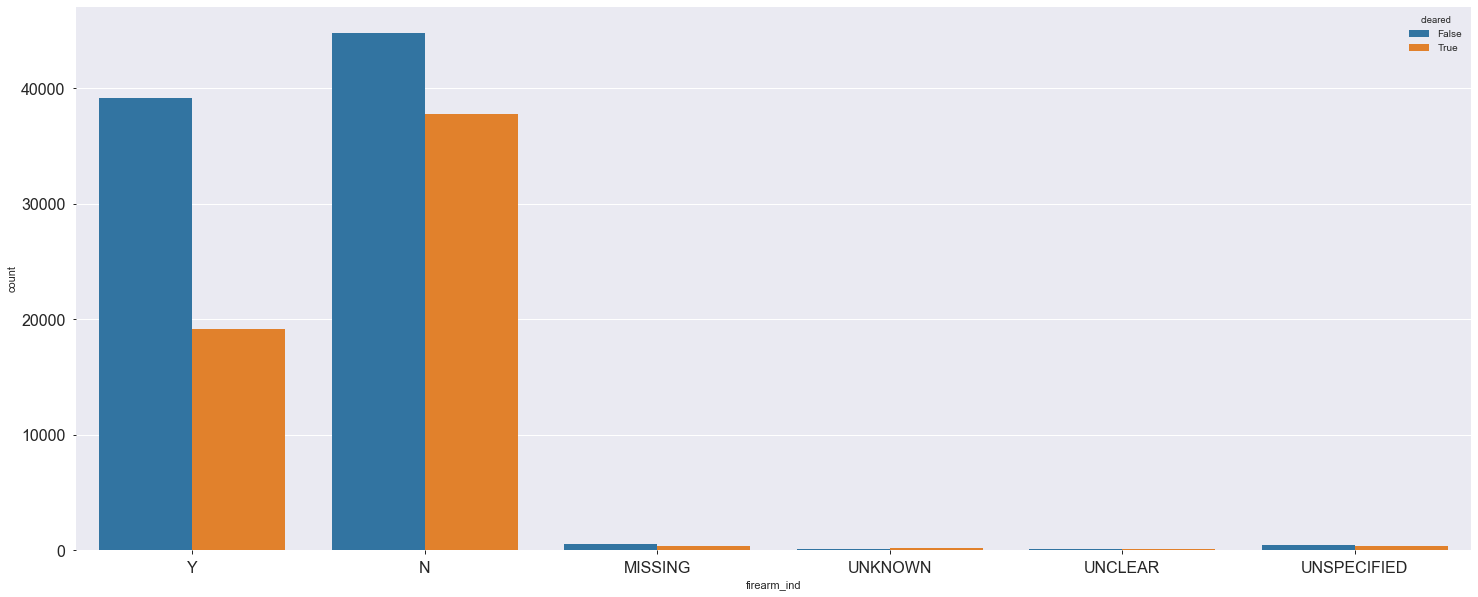

In [47]:
graph_feature("firearm_ind")

Offenses using firearms were cleared at a rate dramatically lower than other crimes.

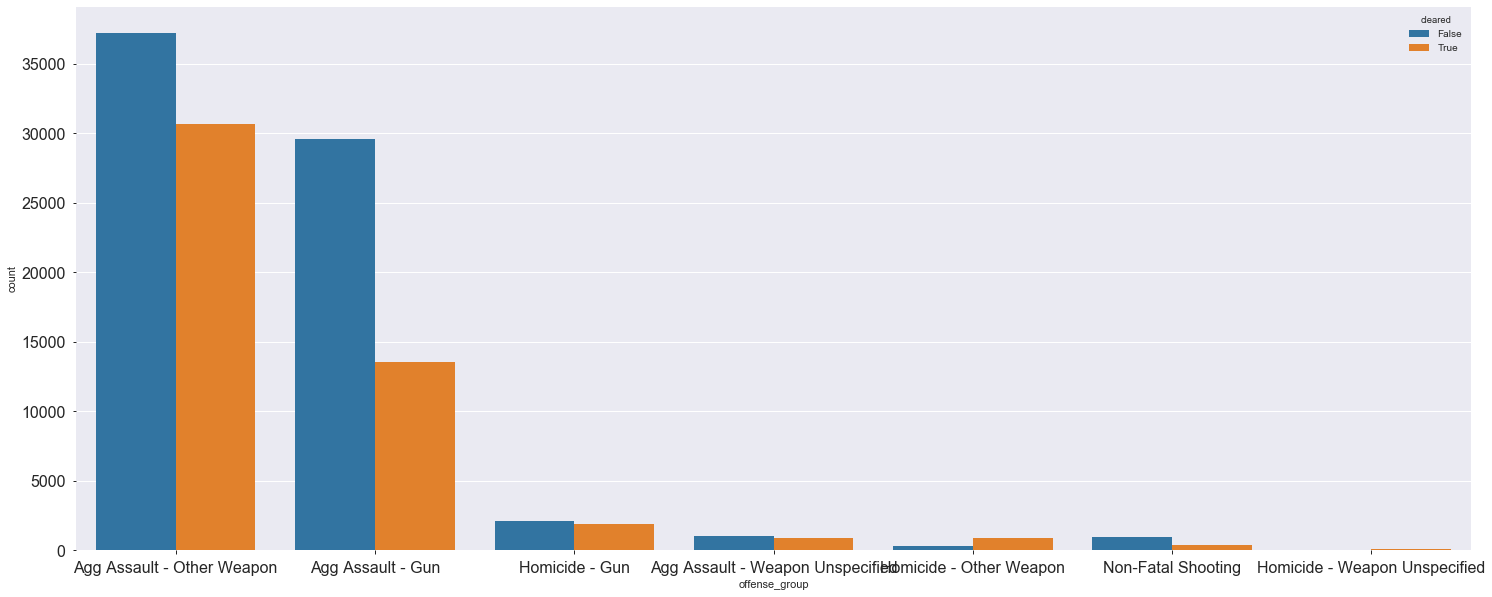

In [25]:
graph_feature("offense_group")

Here we see the effect of firearms broken down by crime. Of note, a substantial majority of homicides committed with non-firearm weapons are cleared.

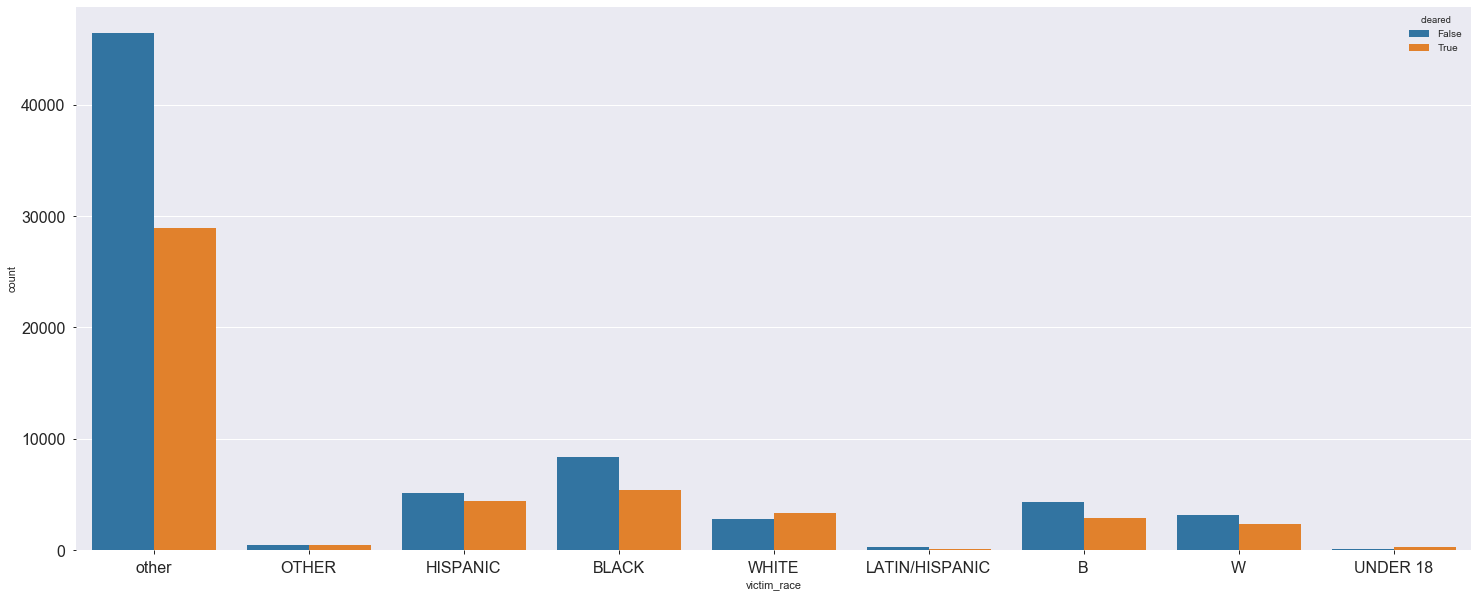

In [26]:
graph_feature("victim_race")

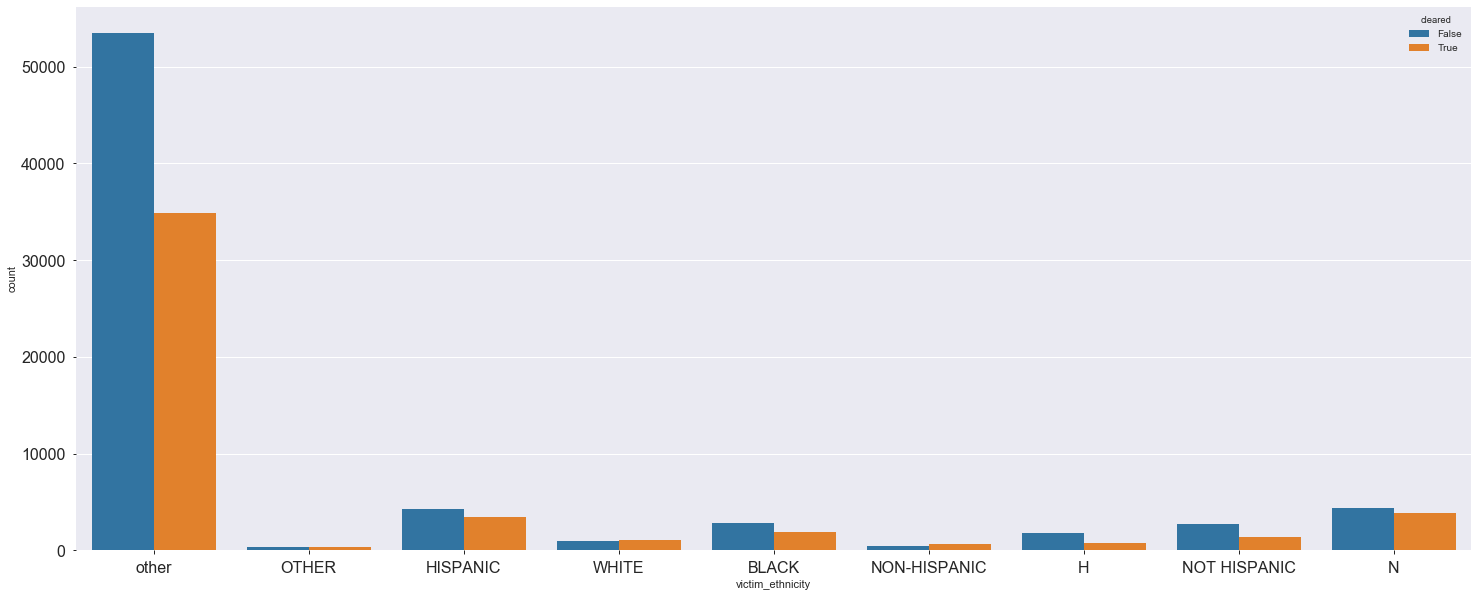

In [27]:
graph_feature("victim_ethnicity")

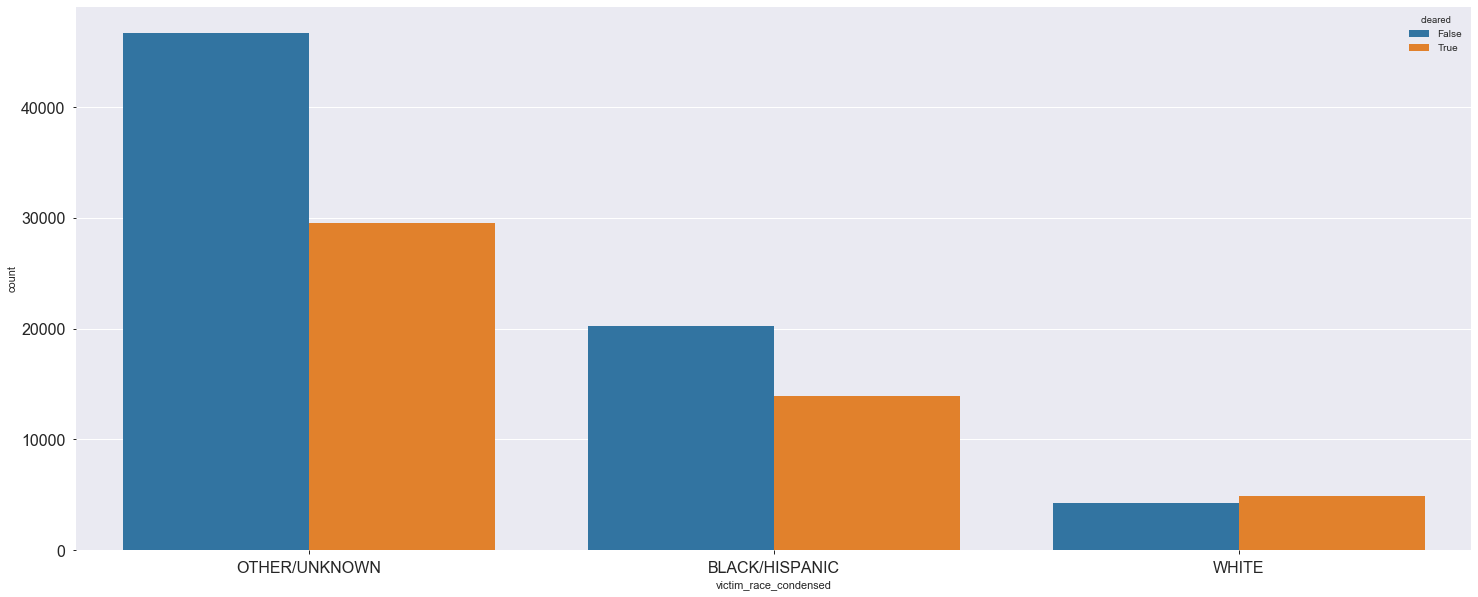

In [28]:
graph_feature("victim_race_condensed")

The condensed victim race represents a combination of the prior two. I graph all because I'm still looking into whether there's a way to separate the middle two.

## Hyperparameter Tuning

In [26]:
X_train.dtypes

agency_name              object
occurred_date            object
occurred_time            object
firearm_ind              object
offense_group            object
domestic_violence_ind    object
victim_age               object
victim_race              object
victim_ethnicity         object
victim_race_condensed    object
victim_sex               object
dtype: object

In [57]:
X_train_full = pd.concat([X_train, X_val], ignore_index = True)
y_train_full = pd.concat([y_train, y_val], ignore_index = True)

Next I do some systematic tuning of the random forest hyperparameters. I want to see how well a Random Forest model tested on the same features as the logistic model does. This updates my baseline; once I fit this and an xgboost model, I'll know about where I'm at before any feature engineering. Then I can accurately assess whether additional features are helping etc.

In [34]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    #handle on a feature's null values feature by feature
    RandomForestClassifier(random_state = 42)
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(100, 1500),
    'randomforestclassifier__max_depth': [5, 15, 25, 40],
    'randomforestclassifier__min_samples_leaf': randint(1, 5)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 7,
    cv = 5,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True,
    n_jobs = -1
    )

search.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed: 26.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 28.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [35]:
print(search.best_params_)
print(search.best_score_)
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 950, 'simpleimputer__strategy': 'mean'}
0.7031202515777198


,6,1,0,5,4,2,3
mean_fit_time,98.1886,139.939,137.509,131.729,54.1329,124.856,187.924
std_fit_time,7.43637,22.0017,2.40338,4.59108,0.609683,15.954,9.72007
mean_score_time,6.69329,10.3923,22.7825,21.4079,2.58521,19.2181,43.8185
std_score_time,1.80318,0.704742,5.47047,4.18432,0.0937726,3.54889,12.4042
param_randomforestclassifier__max_depth,15,15,40,50,5,40,50
param_randomforestclassifier__min_samples_leaf,4,4,3,2,1,2,1
param_randomforestclassifier__n_estimators,950,1254,1116,1026,1199,817,1092
param_simpleimputer__strategy,mean,mean,mean,median,mean,mean,mean
params,"{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 40, 'ran...","{'randomforestclassifier__max_depth': 50, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 40, 'ran...","{'randomforestclassifier__max_depth': 50, 'ran..."
split0_test_score,0.707943,0.707901,0.6961,0.688483,0.688735,0.68886,0.666681


My first model - with a max depth of 25, 4 features per leaf, an imputer strategy of "Median" (no flags), and 328 estimators got a score of .690. This comfortably beats the baseline. Because of a prior hyperparam search that stopped early, I know this isn't even the best model -- 40/4/X/1000 got around .698 -- but this is suitable for me to plot feature importances and start to look at feature engineering, further data cleanup, etc.

I fit a pipeline with the parameters found through param search then plot feature importances.

## Feature Importances

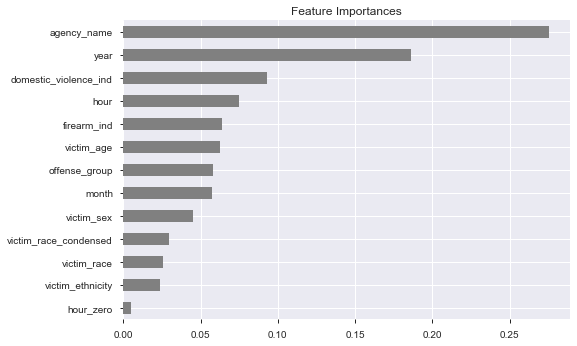

In [58]:
# get feature importances from named steps
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = "mean"),
    RandomForestClassifier(max_depth = 15, n_estimators = 950, min_samples_leaf = 4, random_state = 42)
    )

pipeline.fit(X_train_full, y_train_full)

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
plt.figure()
plt.title("Feature Importances")
importances.sort_values().plot.barh(color='grey');


Next I get the permutation importances for this same model. For my models where I'm not cross-validating, I pull a validation set.

In [38]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model2 = RandomForestClassifier(n_estimators = 1000, random_state = 42, 
                                min_samples_leaf = 4, n_jobs = -1)
model2.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
model2.score(X_val_transformed, y_val)

0.6954720455306327

In [40]:
permuter = PermutationImportance(
    model2,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

# if included in notebook - include it in your story - make sure you actually use it to refine your model

Weight,Feature
0.0887 ± 0.0040,agency_name
0.0473 ± 0.0029,domestic_violence_ind
0.0440 ± 0.0042,firearm_ind
0.0275 ± 0.0027,year
0.0064 ± 0.0021,offense_group
0.0045 ± 0.0009,hour
0.0039 ± 0.0022,victim_sex
0.0023 ± 0.0014,victim_race
0.0020 ± 0.0004,victim_age
0.0018 ± 0.0016,month


## Investigating XGBoost

In [61]:
encoder = ce.OrdinalEncoder()
X_train_full_encoded = encoder.fit_transform(X_train_full)

dtrain = xgb.DMatrix(X_train_full_encoded, label = y_train_full)

C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [64]:
dtrain

In [66]:
params = {
    'n_estimators': 1000,
    'max_depth': 7,
    'learning_rate': .3,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=None, as_pandas = True)

In [67]:
bst_cv.tail()

,train-error-mean,train-error-std,test-error-mean,test-error-std
995,0.180865,0.000684,0.315046,0.002500
996,0.180833,0.000674,0.315085,0.002504
997,0.180746,0.000673,0.315186,0.002632
998,0.180708,0.000664,0.315107,0.002592
999,0.180643,0.000671,0.315141,0.002531


In [79]:
bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
27,0.283119,0.000720,0.296390,0.001540
28,0.282865,0.000760,0.296474,0.001484
25,0.283872,0.000702,0.296530,0.001889
26,0.283546,0.000603,0.296547,0.001698
24,0.284362,0.000834,0.296642,0.002221
...,...,...,...,...
996,0.180833,0.000674,0.315085,0.002504
991,0.181049,0.000740,0.315091,0.002512
998,0.180708,0.000664,0.315107,0.002592
999,0.180643,0.000671,0.315141,0.002531


Our model actually converges extremely quickly here. An early stopping parameter might be appropriate.

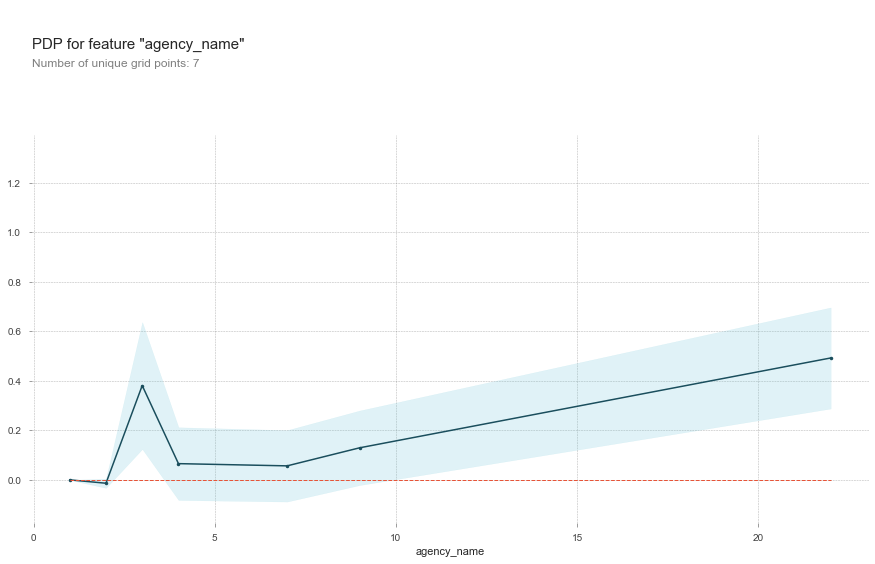

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = "agency_name"
pdp_dist = pdp.pdp_isolate(model = model3, dataset = X_train_encoded, model_features = features, feature = feature)
pdp.pdp_plot(pdp_dist, feature);

In [101]:
filename = "C:/Users/ajenk/GitHub/Crime_Data/offenses-standardized.csv"
random.seed(42)
p = .3
fields = ["agency_name", "occurred_date", 
          "occurred_time", "firearm_ind", "offense_group", "domestic_violence_ind", "victim_age",
          "victim_race", "victim_ethnicity", "victim_race_condensed", "victim_sex", "clearance_group"]

crime = pd.read_csv(filename, skiprows = lambda i: i > 0 and random.random() > p)

train, test = train_test_split(crime, test_size = .2, random_state = 42)
train = create_binary_target(train)
test = create_binary_target(test)

In [81]:
train.head().T

,90716,14331,26979,96014,154950
row_hash,TXDPD0000-2AFC942FBF-01-01,ILCPD0000-42A290B4F2-01-01,ILCPD0000-B478D6B226-01-01,TXHPD0000-1F4A679807-01-01,PAPEP0000-17CAB2C9B4-01-01
source,DALLAS-AGG,CHICAGO-AGG,CHICAGO-AGG,HOUSTON-AGG,PHILADELPHIA-MAIN
agency_name,DALLAS-PD,CHICAGO-PD,CHICAGO-PD,HOUSTON-PD,PHILADELPHIA-PD
agency_ori,TXDPD0000,ILCPD0000,ILCPD0000,TXHPD0000,PAPEP0000
agency_incident_id,165178-2016,HH693071,HL119207,3950408,185499
occurred_date,2016-07-07,2002-10-05,2005-01-12,2008-01-09,2007-02-20
occurred_time,20:54,04:45,01:48,00:15,23:57
offense_category,AGGRAVATED ASSAULT,NaN,NaN,AGGRAVATED ASSAULT,AGG ASSAULT
top_ucr_classification,AGGRAVATED ASSAULT,AGGRAVATED ASSAULT,AGGRAVATED ASSAULT,NaN,AGG ASSAULT
top_local_classification,ASSAULT (AGG) -DEADLY WEAPON,BATTERY AGGRAVATED: OTHER DANG WEAPON,ASSAULT AGGRAVATED:KNIFE/CUTTING INSTR,4041 - AGGRAVATED ASSAULT (D. W.)/BY FIREARMS(FV),417 - AGGRAVATED ASSAULT: DOMESTIC ABUSE: OTHE...


In [103]:
irrelevant = ["row_hash", "agency_ori", "agency_incident_id", "family_violence_ind"]
leakage = ["relationship_to_offender", "arrest_date", "case_status", "arrest_ind",
           "clearance_status", "clearance_date"]
missing = ["family_violence_ind", "inside_outside", "circumstance"]
              

In [89]:
train["gang_activity_ind"].describe()

count     42712
unique       11
top           N
freq      25121
Name: gang_activity_ind, dtype: object

In [104]:
train = train.drop(irrelevant + leakage + missing, axis = 1)

In [94]:
features = train.columns

Index(['source', 'agency_name', 'occurred_date', 'occurred_time',
       'offense_category', 'top_ucr_classification',
       'top_local_classification', 'nibrs_code', 'weapon', 'firearm_ind',
       'offense_group', 'domestic_violence_ind', 'gang_activity_ind',
       'victim_age', 'victim_race', 'victim_ethnicity',
       'victim_race_condensed', 'victim_sex', 'cleared'],
      dtype='object')

In [97]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe()
profile

In [105]:
train = wrangle(train)

features = train.drop([target], axis = 1).columns.to_list()

X_train = train[features]
y_train = train[target]

The list of missing values is ugly. However, XGBoost can often deal well with missing data using a kitchen sink approach. 

In [106]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)

dtrain = xgb.DMatrix(X_train_encoded, label = y_train)

params = {
    'n_estimators': 1000,
    'max_depth': 7,
    'learning_rate': .3,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=None, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-error-mean,train-error-std,test-error-mean,test-error-std
79,0.255353,0.000495,0.286513,0.002372
78,0.255540,0.000396,0.286519,0.002310
77,0.255760,0.000471,0.286524,0.002306
45,0.265815,0.000784,0.286535,0.002436
80,0.255069,0.000565,0.286574,0.002290
...,...,...,...,...
995,0.157780,0.000212,0.303812,0.002865
997,0.157636,0.000217,0.303924,0.002871
996,0.157714,0.000204,0.303930,0.002875
999,0.157495,0.000258,0.303958,0.002757


In [107]:
params = {
    'n_estimators': 1000,
    'max_depth': 7,
    'learning_rate': .1,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=50, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
129,0.267271,0.000769,0.285631,0.001488
124,0.267879,0.000654,0.285648,0.001487
126,0.267756,0.000705,0.285659,0.001334
105,0.269689,0.000494,0.285665,0.001680
122,0.268064,0.000617,0.285670,0.001626
...,...,...,...,...
4,0.293324,0.000650,0.295593,0.002197
3,0.293499,0.000760,0.295833,0.002225
2,0.293994,0.000718,0.296162,0.002221
1,0.294849,0.000861,0.297563,0.002183


In [108]:
params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'learning_rate': .3,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=50, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
309,0.269509,0.001021,0.285537,0.001505
308,0.269528,0.000967,0.285609,0.001297
307,0.269535,0.000966,0.285615,0.001357
300,0.269795,0.000994,0.285631,0.001568
299,0.269839,0.001007,0.285654,0.001550
...,...,...,...,...
4,0.301449,0.000569,0.301525,0.002717
3,0.301958,0.000947,0.302205,0.002677
2,0.305000,0.001545,0.305710,0.004206
1,0.309409,0.001778,0.309650,0.003474


In [109]:
params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'learning_rate': .1,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=50, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
554,0.275703,0.000891,0.285380,0.002160
552,0.275694,0.000865,0.285403,0.002141
536,0.275980,0.000858,0.285419,0.002194
551,0.275699,0.000862,0.285419,0.002188
553,0.275695,0.000875,0.285425,0.002155
...,...,...,...,...
4,0.308493,0.000740,0.308584,0.002657
3,0.308793,0.000692,0.308740,0.002720
2,0.309051,0.000785,0.309181,0.002543
1,0.309626,0.000718,0.309655,0.002592


In [111]:
params = {
    'n_estimators': 1500,
    'max_depth': 2,
    'learning_rate': .2,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
914,0.285319,0.000753,0.289705,0.001955
993,0.284892,0.000788,0.289705,0.001939
990,0.284849,0.000755,0.289710,0.001992
992,0.284874,0.000770,0.289711,0.001942
991,0.284853,0.000759,0.289711,0.001963
...,...,...,...,...
3,0.313818,0.000744,0.313818,0.002976
4,0.315241,0.003541,0.315565,0.002842
2,0.323222,0.000609,0.323222,0.002434
1,0.324142,0.000604,0.324142,0.002417


In [112]:
params = {
    'n_estimators': 1500,
    'max_depth': 3,
    'learning_rate': .2,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
723,0.275718,0.000805,0.285966,0.001546
721,0.275743,0.000802,0.286011,0.001464
722,0.275719,0.000796,0.286011,0.001510
720,0.275762,0.000789,0.286033,0.001491
711,0.275923,0.000772,0.286117,0.001435
...,...,...,...,...
6,0.311384,0.000782,0.311341,0.003123
4,0.311692,0.000730,0.311692,0.002920
3,0.311694,0.000749,0.311698,0.002996
2,0.311705,0.000759,0.311709,0.003036


In [113]:
params = {
    'n_estimators': 1500,
    'max_depth': 3,
    'learning_rate': .15,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
437,0.282441,0.000625,0.287836,0.002457
435,0.282544,0.000671,0.287897,0.002499
436,0.282495,0.000644,0.287919,0.002434
430,0.282654,0.000633,0.287936,0.002487
415,0.282922,0.000651,0.287942,0.002358
...,...,...,...,...
5,0.311702,0.000751,0.311698,0.002998
4,0.311841,0.000778,0.311938,0.002769
2,0.314297,0.003883,0.314722,0.002740
3,0.315212,0.004877,0.315755,0.003417


In [114]:
params = {
    'n_estimators': 1100,
    'max_depth': 4,
    'learning_rate': .2,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
620,0.266309,0.000771,0.284800,0.001829
616,0.266347,0.000771,0.284822,0.001838
612,0.266382,0.000742,0.284833,0.001933
617,0.266341,0.000747,0.284844,0.001821
619,0.266317,0.000765,0.284844,0.001806
...,...,...,...,...
4,0.305178,0.002423,0.305553,0.004603
3,0.308044,0.000787,0.308344,0.002901
2,0.308534,0.000633,0.308545,0.002541
1,0.309331,0.000527,0.309538,0.003015


In [116]:
params = {
    'n_estimators': 750,
    'max_depth': 4,
    'learning_rate': .2,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
620,0.266309,0.000771,0.284800,0.001829
616,0.266347,0.000771,0.284822,0.001838
612,0.266382,0.000742,0.284833,0.001933
617,0.266341,0.000747,0.284844,0.001821
619,0.266317,0.000765,0.284844,0.001806
...,...,...,...,...
4,0.305178,0.002423,0.305553,0.004603
3,0.308044,0.000787,0.308344,0.002901
2,0.308534,0.000633,0.308545,0.002541
1,0.309331,0.000527,0.309538,0.003015


In [117]:
params = {
    'n_estimators': 750,
    'max_depth': 4,
    'learning_rate': .25,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

,train-error-mean,train-error-std,test-error-mean,test-error-std
226,0.274681,0.000472,0.285654,0.002352
221,0.274927,0.000495,0.285726,0.002154
217,0.275172,0.000437,0.285737,0.002261
225,0.274709,0.000452,0.285804,0.002331
216,0.275217,0.000423,0.285804,0.002294
...,...,...,...,...
4,0.306163,0.002307,0.306597,0.004461
3,0.307063,0.000157,0.307351,0.003551
2,0.307097,0.001525,0.307457,0.003489
1,0.309436,0.000687,0.309633,0.003655


In [121]:
train, val = train_test_split(train, test_size = .2, random_state = 42)

In [122]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [124]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model3 = XGBClassifier(
    n_estimators = 1000,
    max_depth = 4,
    learning_rate = .2,
    n_jobs = -1,)


eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model3.fit(X_train_encoded,
          y_train,
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds = 90
          )

[0]	validation_0-error:0.320677	validation_1-error:0.31995
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90 rounds.
[1]	validation_0-error:0.312258	validation_1-error:0.312305
[2]	validation_0-error:0.31232	validation_1-error:0.310965
[3]	validation_0-error:0.30312	validation_1-error:0.304464
[4]	validation_0-error:0.304187	validation_1-error:0.305859
[5]	validation_0-error:0.302827	validation_1-error:0.303711
[6]	validation_0-error:0.302485	validation_1-error:0.303683
[7]	validation_0-error:0.302234	validation_1-error:0.303655
[8]	validation_0-error:0.300406	validation_1-error:0.301646
[9]	validation_0-error:0.300608	validation_1-error:0.301953
[10]	validation_0-error:0.300141	validation_1-error:0.301395
[11]	validation_0-error:0.299283	validation_1-error:0.300307
[12]	validation_0-error:0.29869	validation_1-error:0.29947
[13]	validation_0-error:0.297839	validation_1-error:0.299275


[132]	validation_0-error:0.282032	validation_1-error:0.28644
[133]	validation_0-error:0.281914	validation_1-error:0.286356
[134]	validation_0-error:0.281851	validation_1-error:0.286217
[135]	validation_0-error:0.281795	validation_1-error:0.285937
[136]	validation_0-error:0.28176	validation_1-error:0.285937
[137]	validation_0-error:0.281753	validation_1-error:0.285882
[138]	validation_0-error:0.281732	validation_1-error:0.285965
[139]	validation_0-error:0.281725	validation_1-error:0.285882
[140]	validation_0-error:0.281642	validation_1-error:0.285965
[141]	validation_0-error:0.2816	validation_1-error:0.286049
[142]	validation_0-error:0.281509	validation_1-error:0.286161
[143]	validation_0-error:0.281509	validation_1-error:0.28577
[144]	validation_0-error:0.281349	validation_1-error:0.285993
[145]	validation_0-error:0.2813	validation_1-error:0.285965
[146]	validation_0-error:0.281216	validation_1-error:0.285937
[147]	validation_0-error:0.281279	validation_1-error:0.285882
[148]	validatio

[265]	validation_0-error:0.275887	validation_1-error:0.284487
[266]	validation_0-error:0.275817	validation_1-error:0.284515
[267]	validation_0-error:0.275754	validation_1-error:0.284487
[268]	validation_0-error:0.275775	validation_1-error:0.284682
[269]	validation_0-error:0.275726	validation_1-error:0.284515
[270]	validation_0-error:0.275698	validation_1-error:0.28457
[271]	validation_0-error:0.275712	validation_1-error:0.284654
[272]	validation_0-error:0.275656	validation_1-error:0.284626
[273]	validation_0-error:0.275545	validation_1-error:0.284682
[274]	validation_0-error:0.275426	validation_1-error:0.28471
[275]	validation_0-error:0.275266	validation_1-error:0.284738
[276]	validation_0-error:0.275196	validation_1-error:0.284766
[277]	validation_0-error:0.275161	validation_1-error:0.284849
[278]	validation_0-error:0.275133	validation_1-error:0.284877
[279]	validation_0-error:0.275119	validation_1-error:0.284877
[280]	validation_0-error:0.275098	validation_1-error:0.284877
[281]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

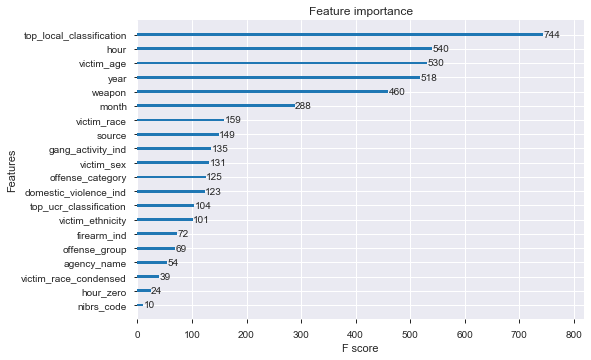

In [126]:
xgb.plot_importance(model3);

In [127]:
print(model3.score(X_val_encoded, y_val))
model3.get_params


0.7165178571428571


<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>

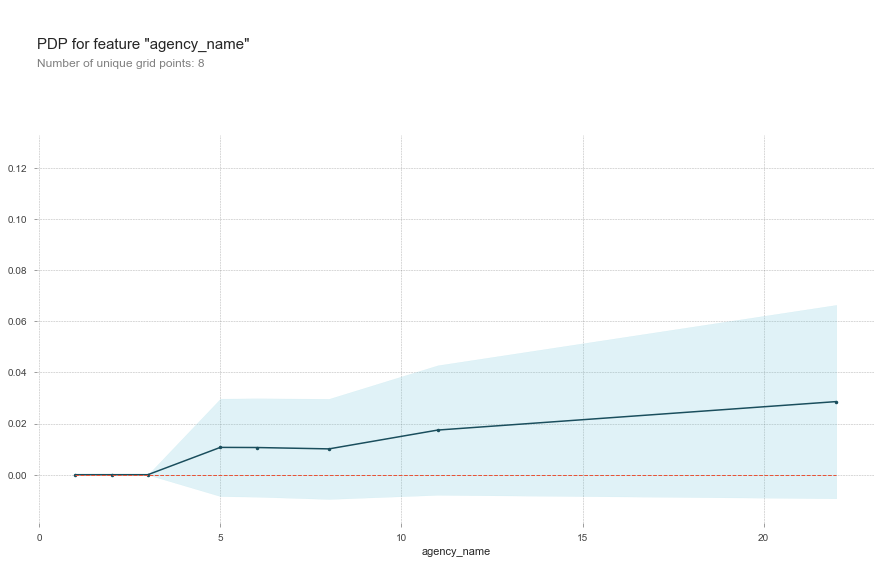

In [131]:
%matplotlib inline
feature = "agency_name"
pdp_dist = pdp.pdp_isolate(model = model3, 
                                 dataset = X_train_encoded, 
                                 model_features = features, 
                                 feature = feature)
pdp.pdp_plot(pdp_dist, feature);

In [133]:
feature = "victim_age"
pdp_dist = pdp.pdp_isolate(model = model3, 
                                 dataset = X_train_encoded, 
                                 model_features = features, 
                                 feature = feature)
pdp.pdp_plot(pdp_dist, feature);

ValueError: No objects to concatenate